# Federal Scorecard Data Analysis
- situation: Increase enrollments and income by leveraging data in marketing materials.
- complication: how can we determine what colleges are similar, and what statistics to cite
- question: how does tcnj compare to similar schools with regard to student success
- answer: TCNJ students earn among the top schools with simlar offerings and carry signficantly less debt after graduation.  
- support:
    - item 1: similar schools - 200 schools were found to have simlar degrees by field of study
    - item 2: student income after graduation is higher than average and among the top 5%
    - item 3: student debt after graduation is 10% below 
    
### possible improvements
- weight simlarity of schools by degrees are most pursued at the institution
    - need attendance data or another metric that generally reflects activity in each field
    - attempt to use count of students with debt (BBRR2_FED_COMP_N) was not successful 
- compare alternative clustering algorithms and choose the best by comparing silhouette plots, cohesion, and separation 
- use additional features to determine schools similarity: campus size, student population, student/teacher ratio
- increase transparency by using tree-based clustering to highlight differentiating factors
- join with additional datasets to make the analysis more robust
- improve visualizations
    - add average and 95th percentile as additional bars for reference
    - custom annotations highlighting the percent difference for TCNJ vs reference metrics

In [7]:
import highered as h
import pandas as pd
import sqlalchemy as sa
import numpy as np

In [3]:
db = sa.create_engine('sqlite:///ignoredir/highered.sqlite')
datadf = pd.read_sql('select * from dictionary', db)
from functools import partial
get_col_info = partial(h.get_col_info, datadf)
get_col_info('earn_mdn', map='program')

,id,source,type,map,description,index,lvl_0,lvl_1,lvl_2,lvl_3,lvl_4,calculate
2469,programs.cip_4_digit.earnings.highest.1_yr.o...,P_EARN_MDN_HI_1YR,integer,program,Median earnings of graduates working and not e...,None,None,None,None,None,None,None
2473,programs.cip_4_digit.earnings.highest.2_yr.o...,P_EARN_MDN_HI_2YR,integer,program,Median earnings of graduates working and not e...,integer,None,None,None,None,None,None


## what colleges are similar to this one
- data source: field of study data (current cohort)
- cluster the data and look at which schools are in the same cluster
- degree programs are currently a row feature and need to be transformed to one-hot encoded set of features

In [15]:
tcnj_opeid = '00264200'
tcnj_opeid6 = 2642 #need to convert to int for opeid6
tcnj_unitid = 187134

In [20]:
fosdf = h.df_from_zipcsv(h.ZIPNAME, 'Most-Recent-Cohorts-Field-of-Study.csv', )
fosdf = fosdf.replace(-1, np.nan)
fosdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260531 entries, 0 to 260530
Data columns (total 92 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   UNITID                         253808 non-null  float64
 1   OPEID6                         260531 non-null  int64  
 2   INSTNM                         260531 non-null  object 
 3   CONTROL                        260531 non-null  object 
 4   MAIN                           260531 non-null  int64  
 5   CIPCODE                        260531 non-null  int64  
 6   CIPDESC                        260531 non-null  object 
 7   CREDLEV                        260531 non-null  int64  
 8   CREDDESC                       260531 non-null  object 
 9   IPEDSCOUNT1                    187439 non-null  float64
 10  IPEDSCOUNT2                    189508 non-null  float64
 11  DEBT_ALL_STGP_ANY_N            52500 non-null   float64
 12  DEBT_ALL_STGP_ANY_MEAN        

In [21]:
fosdf.sample(5)

,UNITID,OPEID6,INSTNM,CONTROL,MAIN,CIPCODE,CIPDESC,CREDLEV,CREDDESC,IPEDSCOUNT1,...,EARN_MDN_HI_2YR,BBRR2_FED_COMP_N,BBRR2_FED_COMP_DFLT,BBRR2_FED_COMP_DLNQ,BBRR2_FED_COMP_FBR,BBRR2_FED_COMP_DFR,BBRR2_FED_COMP_NOPROG,BBRR2_FED_COMP_MAKEPROG,BBRR2_FED_COMP_PAIDINFULL,BBRR2_FED_COMP_DISCHARGE
149185,210076.0,23301,Pioneer Pacific College,"Private, for-profit",1,5203,Accounting and Related Services.,2,Associate's Degree,11.0,...,26353.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148913,209807.0,3216,Portland State University,Public,1,4201,"Psychology, General.",5,Master's Degree,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167031,217484.0,3414,University of Rhode Island,Public,1,1424,Ocean Engineering.,6,Doctoral Degree,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236542,460394.0,41735,Moreno Valley College,Public,1,4201,"Psychology, General.",2,Associate's Degree,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112120,190512.0,7273,CUNY Bernard M Baruch College,Public,1,5218,"General Sales, Merchandising and Related Marke...",3,Bachelors Degree,371.0,...,41837.0,100.0,NaN,NaN,NaN,NaN,0.19,0.46,0.19,NaN


In [28]:
subfosdf = fosdf.query('UNITID == @tcnj_unitid')
subfosdf.sample(4)

,UNITID,OPEID6,INSTNM,CONTROL,MAIN,CIPCODE,CIPDESC,CREDLEV,CREDDESC,IPEDSCOUNT1,...,EARN_MDN_HI_2YR,BBRR2_FED_COMP_N,BBRR2_FED_COMP_DFLT,BBRR2_FED_COMP_DLNQ,BBRR2_FED_COMP_FBR,BBRR2_FED_COMP_DFR,BBRR2_FED_COMP_NOPROG,BBRR2_FED_COMP_MAKEPROG,BBRR2_FED_COMP_PAIDINFULL,BBRR2_FED_COMP_DISCHARGE
106769,187134.0,2642,The College of New Jersey,Public,1,1311,Student Counseling and Personnel Services.,5,Master's Degree,44.0,...,51169.0,24.0,NaN,NaN,NaN,NaN,0.458333,NaN,NaN,NaN
106778,187134.0,2642,The College of New Jersey,Public,1,1405,Biomedical/Medical Engineering.,3,Bachelors Degree,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106781,187134.0,2642,The College of New Jersey,Public,1,1410,"Electrical, Electronics and Communications Eng...",3,Bachelors Degree,15.0,...,68219.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106783,187134.0,2642,The College of New Jersey,Public,1,1419,Mechanical Engineering.,3,Bachelors Degree,16.0,...,58402.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- assumption 1: proportion of students within a given program that carry debt will be similar so the most popular degrees are those tha have the highest count of student debt measures P_BBRR2_FED_COMP_N

In [65]:
subfosdf.isnull().sum().sum()

3787

In [77]:
subfosdf.isnull().sum().sum()/subfosdf.count().sum()

2.599176389842141

In [74]:
harvard =fosdf[fosdf['INSTNM'].str.contains('harvard uni', flags=2)]
harvard.isnull().sum().sum()/harvard.count().sum()

5.561704646345072

In [73]:
princeton = fosdf[fosdf['INSTNM'].str.contains('princeton uni', flags=2)]
princeton.isnull().sum().sum()/princeton.count().sum()

6.661016949152542

In [57]:
subfosdf.groupby('CIPDESC')['BBRR2_FED_COMP_N'].sum().sort_values(ascending=False).head(5)

CIPDESC
Business Administration, Management and Operations.                             180.0
Teacher Education and Professional Development, Specific Levels and Methods.    122.0
Teacher Education and Professional Development, Specific Subject Areas.         112.0
Communication and Media Studies.                                                 86.0
Psychology, General.                                                             57.0
Name: BBRR2_FED_COMP_N, dtype: float64

In [58]:
fosdf[fosdf['INSTNM'].str.contains('harvard uni', flags=2)].groupby('CIPDESC')['BBRR2_FED_COMP_N'].sum().sort_values(ascending=False).head(5)

CIPDESC
Law.                                                   732.0
Education, General.                                    578.0
Business Administration, Management and Operations.    396.0
Medicine.                                              154.0
Public Policy Analysis.                                139.0
Name: BBRR2_FED_COMP_N, dtype: float64

In [59]:
fosdf[fosdf['INSTNM'].str.contains('yale uni', flags=2)].groupby('CIPDESC')['BBRR2_FED_COMP_N'].sum().sort_values(ascending=False).head(5)

CIPDESC
Law.                                                                                  238.0
Business Administration, Management and Operations.                                   196.0
Theological and Ministerial Studies.                                                   94.0
Medicine.                                                                              90.0
Registered Nursing, Nursing Administration, Nursing Research and Clinical Nursing.     79.0
Name: BBRR2_FED_COMP_N, dtype: float64

In [55]:
fosdf[fosdf['INSTNM'].str.contains('princeton uni', flags=2)].groupby('CIPDESC')['DEBT_ALL_STGP_EVAL_N'].sum().sort_values(ascending=False).head(5)

CIPDESC
Economics.                           17.0
Public Policy Analysis.              17.0
History.                             16.0
Political Science and Government.    12.0
Architecture.                        10.0
Name: DEBT_ALL_STGP_EVAL_N, dtype: float64

In [60]:
fosdf[fosdf['INSTNM'].str.contains('princeton uni', flags=2)]

,UNITID,OPEID6,INSTNM,CONTROL,MAIN,CIPCODE,CIPDESC,CREDLEV,CREDDESC,IPEDSCOUNT1,...,EARN_MDN_HI_2YR,BBRR2_FED_COMP_N,BBRR2_FED_COMP_DFLT,BBRR2_FED_COMP_DLNQ,BBRR2_FED_COMP_FBR,BBRR2_FED_COMP_DFR,BBRR2_FED_COMP_NOPROG,BBRR2_FED_COMP_MAKEPROG,BBRR2_FED_COMP_PAIDINFULL,BBRR2_FED_COMP_DISCHARGE
105217,186131.0,2627,Princeton University,"Private, nonprofit",1,301,Natural Resources Conservation and Research.,5,Master's Degree,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105218,186131.0,2627,Princeton University,"Private, nonprofit",1,301,Natural Resources Conservation and Research.,6,Doctoral Degree,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105219,186131.0,2627,Princeton University,"Private, nonprofit",1,402,Architecture.,3,Bachelors Degree,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105220,186131.0,2627,Princeton University,"Private, nonprofit",1,402,Architecture.,5,Master's Degree,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105221,186131.0,2627,Princeton University,"Private, nonprofit",1,402,Architecture.,6,Doctoral Degree,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105325,186131.0,2627,Princeton University,"Private, nonprofit",1,5009,Music.,5,Master's Degree,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105326,186131.0,2627,Princeton University,"Private, nonprofit",1,5009,Music.,6,Doctoral Degree,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105327,186131.0,2627,Princeton University,"Private, nonprofit",1,5401,History.,3,Bachelors Degree,84.0,...,43798.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105328,186131.0,2627,Princeton University,"Private, nonprofit",1,5401,History.,5,Master's Degree,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## encoding categorical data
nominal data with no inherent order must be one-hot encoded 

In [86]:
from sklearn.preprocessing import OneHotEncoder
cipcode_ohe = OneHotEncoder()
vals = cipcode_ohe.fit_transform(fosdf['CIPCODE'].values.reshape(-1, 1))

In [93]:
ohe_deg = pd.DataFrame(vals.todense(), index = fosdf['INSTNM'], columns = cipcode_ohe.categories_)
ohe_deg.sample(10)

,100,101,102,103,104,105,106,107,108,109,...,5401,6001,6002,6003,6004,6005,6108,6115,6124,6126
INSTNM,,,,,,,,,,,,,,,,,,,,,
University of Akron Main Campus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pennsylvania State University-Penn State Erie-Behrend College,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cornell University,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Traviss Technical College,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fortis Institute-Erie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pierce College District,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Purdue University Fort Wayne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The University of Texas Permian Basin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Southern Union State Community College,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


confirming that no rows have a value > 1

In [117]:
ohe_deg.T.sum()

INSTNM
Alabama A & M University    1.0
Alabama A & M University    1.0
Alabama A & M University    1.0
Alabama A & M University    1.0
Alabama A & M University    1.0
                           ... 
Compton College             1.0
Compton College             1.0
Compton College             1.0
Compton College             1.0
Compton College             1.0
Length: 260531, dtype: float64

In [107]:
ohe_degbynm = ohe_deg.groupby('INSTNM').sum()
ohe_degbynm.sample(10).sample(10, axis=1)

,3199,3999,1439,4601,1410,301,1420,1402,1607,4207
INSTNM,,,,,,,,,,
D A Dorsey Technical College,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Empire Beauty School-West Mifflin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Clovis Adult Education,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
East Texas Baptist University,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Westwood College - O'Hare Airport,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bancroft School of Massage Therapy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Huntington University,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Day Spa Career College,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Modesto Junior College,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


confirming that there are multiple hot degrees for each row

In [118]:
(ohe_degbynm.T > 1).sum().sort_values(ascending=False).head()

INSTNM
Pennsylvania State University-Main Campus    139
University of Arizona                        135
New York University                          126
University of Washington-Seattle Campus      125
University of Minnesota-Twin Cities          125
dtype: int64

# clustering to find similar schools
multiple settings for linkage and n_clusters are tested to determine which gives a relatively even distribution of cluster members, and minimizes the number of clusters with only 1 member

In [146]:
%%time 
from sklearn.cluster import AgglomerativeClustering
agcluster = AgglomerativeClustering(linkage='ward', n_clusters=75).fit_predict(ohe_degbynm.values)#ward
#bad: averge, complete, single

Wall time: 14.5 s


In [137]:
len(agcluster), len(ohe_degbynm)

(7643, 7643)

In [138]:
np.unique(agcluster)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

In [173]:
sch_clusters = pd.DataFrame(agcluster, index=ohe_degbynm.index, columns = ['cluster',])
tcnj_cluster = sch_clusters[sch_clusters.index.str.contains('The College of New Jersey')]
tcnj_cluster = tcnj_cluster.iloc[0,0]
sim_schools = sch_clusters[sch_clusters['cluster']==tcnj_cluster]
print(f"number of schools simlar to this one by degrees offered is {len(sim_schools)} ({100*len(sim_schools)/len(sch_clusters):.2f}% of all schools)")
sim_schools.sample(10)

number of schools simlar to this one by degrees offered is 200 (2.62% of all schools)


,cluster
INSTNM,
University of Montevallo,7
Loyola University Maryland,7
Florida Memorial University,7
Saint Martin's University,7
Spring Arbor University,7
Missouri Baptist University,7
Furman University,7
California State University-San Marcos,7
Palm Beach Atlantic University,7


In [181]:
simfosdf = fosdf[fosdf['INSTNM'].isin(sim_schools.index)]
print(f"datset size is now {100*len(simfosdf)/len(fosdf):.2f}% of original")

datset size is now 4.19% of original


## what colleges yield highest earnings for students

In [189]:
get_col_info('EARN', map='program')[['source', 'description']].values

array([['P_EARN_COUNT_NWNE_HI_1YR',
        'Number of graduates not working and not enrolled 1 year after completing highest credential'],
       ['P_EARN_COUNT_WNE_HI_1YR',
        'Number of graduates working and not enrolled 1 year after completing highest credential'],
       ['P_EARN_MDN_HI_1YR',
        'Median earnings of graduates working and not enrolled 1 year after completing highest credential'],
       ['P_EARN_CNTOVER150_HI_1YR',
        'Number of graduates working and not enrolled who earned more than 150% of the single-person household poverty threshold 1 year after completing highest credential.'],
       ['P_EARN_COUNT_NWNE_HI_2YR',
        'Number of graduates not working and not enrolled 2 years after completing highest credential'],
       ['P_EARN_COUNT_WNE_HI_2YR',
        'Number of graduates working and not enrolled 2 years after completing highest credential'],
       ['P_EARN_MDN_HI_2YR',
        'Median earnings of graduates working and not enrolled 2 year

**EARN_MDN_HI_2YR** - Median earnings of graduates working and not enrolled 2 years after completing highest credential

In [201]:
fosearn=simfosdf.groupby('INSTNM')['EARN_MDN_HI_2YR'].median().dropna().sort_values()
fosearn.tail()

INSTNM
Trevecca Nazarene University                               56641.0
Teachers College at Columbia University                    61272.5
Antioch University-PhD Program in Leadership and Change    62012.0
Alliant International University-San Diego                 63253.0
Southwestern Adventist University                          66941.0
Name: EARN_MDN_HI_2YR, dtype: float64

In [207]:
custearn = fosearn[fosearn.index.str.contains('College of New J')]
custearn = custearn.append(fosearn.tail(5))
custearn = custearn.append(fosearn.head(5))

<ipython-input-246-5ce424454625>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["${:,.0f}".format(x) for x in ax.get_xticks()])


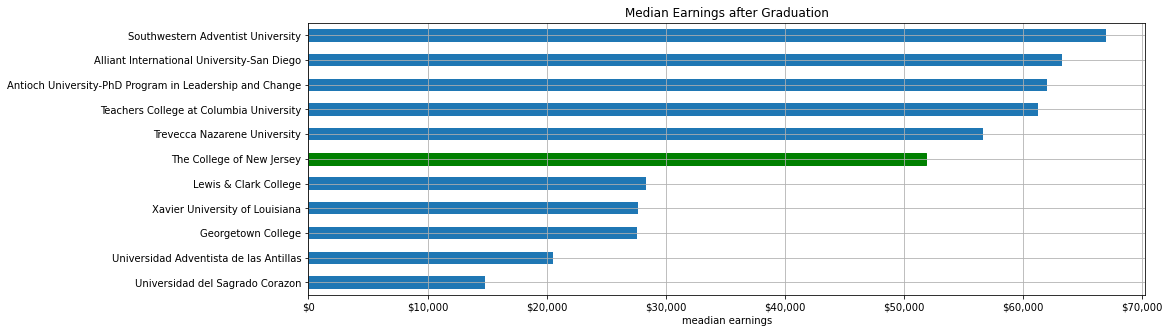

In [246]:
ax = custearn.sort_values().plot.barh(figsize=(15,5), grid=True, title = 'Median Earnings after Graduation')
fig = ax.get_figure()
ax.set_xlabel('meadian earnings')
ax.set_xticklabels(["${:,.0f}".format(x) for x in ax.get_xticks()])
ax.set_ylabel(None)
ax.get_children()[5].set_color('g')


In [268]:
print(f"Earnings for TCNJ students is {100*(fosearn.loc['The College of New Jersey']/fosearn.quantile(.95)-1):.2f}% higher than similar top schools")

Earnings for TCNJ students is 0.96% higher than similar top schools


In [272]:
print(f"Earnings for TCNJ students is {100*(fosearn.loc['The College of New Jersey']/fosearn.mean()-1):.2f}% higher than the average for schools with similar offerings")

Earnings for TCNJ students is 32.86% higher than the average for schools with similar offerings


## what colleges yield the lowest debt for students

In [195]:
get_col_info('DEBT_ALL_STGP_EVAL', map='program')[['source', 'description']].values

array([['P_DEBT_ALL_STGP_EVAL_N',
        'Borrower count for average/median Stafford and Grad PLUS loan debt disbursed at this institution'],
       ['P_DEBT_ALL_STGP_EVAL_MEAN',
        'Average Stafford and Grad PLUS loan debt disbursed at this institution'],
       ['P_DEBT_ALL_STGP_EVAL_MDN',
        'Median Stafford and Grad PLUS loan debt disbursed at this institution'],
       ['P_DEBT_ALL_STGP_EVAL_MDN10YRPAY',
        'Median estimated monthly payment for Stafford and Grad PLUS loan debt disbursed at this institution']],
      dtype=object)

**DEBT_ALL_STGP_EVAL_MDN** - Median Stafford and Grad PLUS loan debt disbursed at this institution

In [200]:
fosdebt = simfosdf.groupby('INSTNM')['DEBT_ALL_STGP_EVAL_MDN'].median().dropna().sort_values()
fosdebt.head()

INSTNM
Texas A&M University-San Antonio     8910.0
Universidad del Sagrado Corazon     11850.0
Western Governors University        13198.5
Brigham Young University-Hawaii     13250.0
SUNY College at Old Westbury        17000.0
Name: DEBT_ALL_STGP_EVAL_MDN, dtype: float64

In [222]:
custdebt = fosdebt[fosdebt.index.str.contains('College of New J')]
custdebt = custdebt.append(fosdebt.tail(5))
custdebt = custdebt.append(fosdebt.head(5))

<ipython-input-245-61aa12714c8d>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["${:,.0f}".format(x) for x in ax.get_xticks()])


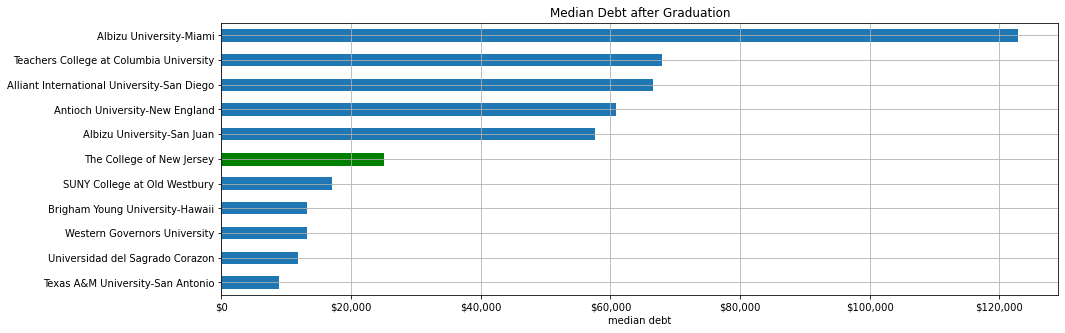

In [245]:
ax = custdebt.sort_values().plot.barh(figsize=(15,5), grid=True, title = 'Median Debt after Graduation')
fig = ax.get_figure()
ax.set_xlabel('median debt')
ax.set_xticklabels(["${:,.0f}".format(x) for x in ax.get_xticks()])
ax.set_ylabel(None)
ax.get_children()[5].set_color('g')

In [261]:
print(f"Debt for TCNJ students is {100*(1-fosdebt.loc['The College of New Jersey']/fosdebt.quantile(.95)):.2f}% below the highest simlar schools")

Debt for TCNJ students is 39.28% below the highest simlar schools


In [273]:
print(f"Debt for TCNJ students is {100*(1-fosdebt.loc['The College of New Jersey']/fosdebt.mean()):.2f}% below the average for schools with similar offerings")

Debt for TCNJ students is 9.32% below the average for schools with similar offerings
